# sai: spooky author identification
## analysis 2: refine simple practices

## strategy
The dataset is the training set.  The training set has three attributes: ID, author, and text class.  This is a multi-class text classification algorithm; this will determine the probability of who wrote which text based on the word usage and several machine learning algorithms.  

The strategy is to use the training set and perform two experiments.  Before performing the experiments, parameter tuning would be performed beforehand to save time and execution.  After that the two experiments are shown below.

The first experiment would include:

* Feature selection (split)
* Feature extraction (vectorize)
* Classification processing (fit/predict)
* Metrics (evaluate)
* Identification (identify)

Then the second experiment would include:

* Feature extraction (vectorize)
* Feature selection (split)
* Classification processing (fit/predict)
* Metrics (evaluate)
* Identification (identify)

Here, the first two are switch.  Vectorize the entire set and then perform classical machine learning.  This will be a good example.  

For now, the algorithmss are:
* vectorizer: CountVectorizer()
* classification: Naive Bayes (MultinomialNB()), Logistic Regression (LogisticsRegression())


| ALGORITHM | STEP | VECTORIZER | CLASSIFIER |
|---|---|---|---|
|1| A | CountVectorizer | MultinomialNB |
|2| B | CountVectorizer | MultinomialNB |
|3| A | CountVectorizer | LogisticRegression |
|4| B | CountVectorizer | LogisticRegression |


## code
### preliminaries
This is the 'de facto' run, where it loads libraries and necessary modules to perform the analysis.  Afterwards, it will read a simple csv file into a dataframe called 'texts.'  

In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.cross_validation import train_test_split             # cross-validation
from sklearn.feature_extraction.text import CountVectorizer       # vectorizer
from sklearn.naive_bayes import MultinomialNB                     # classifier
from sklearn.linear_model import LogisticRegression               # classifier
from sklearn.model_selection import GridSearchCV                  # parameter tuning
from sklearn.pipeline import Pipeline                             # pipeline
from sklearn import metrics                                       # metrics


# other modules
from stop_words import get_stop_words
from pprint import pprint


# Read training texts: texts
texts = pd.read_csv('train.csv')

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### exploratory data analysis
This explores the dataset imported.  The first analysis is size by author, or how many observations per author.  Notice how EAP (Edgar Allen Poe) has the most while HPL (HP Lovecraft) had over 5,600.  But the spread was not substantial; the maximum difference between Poe's prose and Lovecraft's were about 2,265.  MWS (Mary W Shelley) was in the middle.  This also created an arbitrary attribute, length, which will not help with identification but does provide an idea of whose words will weigh the most and how influential the bulk will be.

In [2]:
# Texts as snipnet
texts.loc[3,'text']

'How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.'

In [3]:
# Texts per author
texts.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [4]:
# Texts size, test size
texts.groupby('author').describe()

id                       text         \
       count unique      top freq count unique   
author                                           
EAP     7900   7900  id21252    1  7900   7900   
HPL     5635   5635  id04402    1  5635   5635   
MWS     6044   6044  id24868    1  6044   6044   

                                                                
                                                      top freq  
author                                                          
EAP                           In that chamber was I born.    1  
HPL     And as I ran along the shore, crushing sleepin...    1  
MWS     "You need not wonder that I freely discover Ad...    1

In [5]:
texts['length'] = texts['text'].apply(len)
texts.head() 

,id,text,author,length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


In [6]:
texts.length.describe().apply(round)

count    19579
mean       149
std        107
min         21
25%         81
50%        128
75%        191
max       4663
Name: length, dtype: int64

In [7]:
texts.groupby('author').length.describe().transpose().apply(round)

author,EAP,HPL,MWS
count,7900.0,5635.0,6044.0
mean,142.0,156.0,152.0
std,106.0,82.0,126.0
min,21.0,21.0,21.0
25%,68.0,98.0,84.0
50%,115.0,142.0,130.0
75%,186.0,196.0,192.0
max,1533.0,900.0,4663.0


These length statistics may say little but still imply a lot.  All three will have text with no less than 21 words.  Also, 75% of the texts will contain about 190 words.  Between 75% and 100%, outliers will appear.  For instance, one of Mary Shelley's prose contains 4,663 words alone.  The histograms of the prose count by words is shown below, both as a total and by author.  

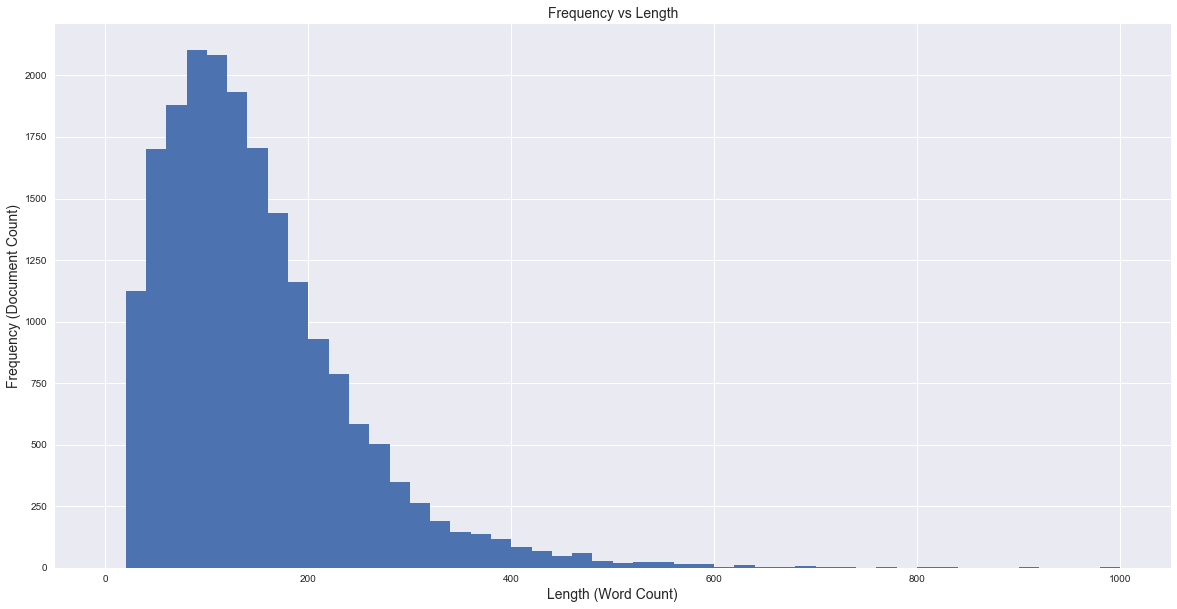

In [8]:
texts['length'].plot(bins=50,kind = 'hist',range=[0,1000], figsize=(20,10))
plt.title('Frequency vs Length', size=14)
plt.xlabel('Length (Word Count)',size=14)
plt.ylabel('Frequency (Document Count)',size=14)

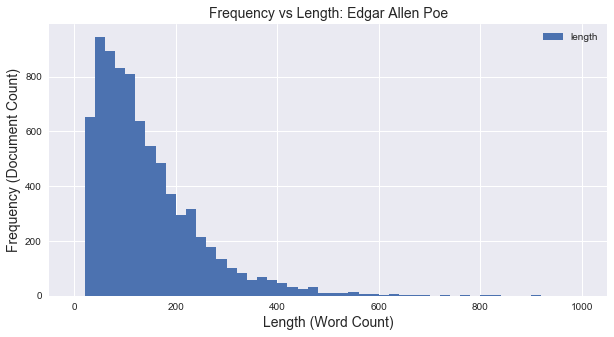

In [9]:
texts[texts.author=='EAP'].plot(bins=50, kind='hist', range=[0,1000], figsize=(10,5))
plt.title('Frequency vs Length: Edgar Allen Poe', size=14)
plt.xlabel('Length (Word Count)',size=14)
plt.ylabel('Frequency (Document Count)',size=14)

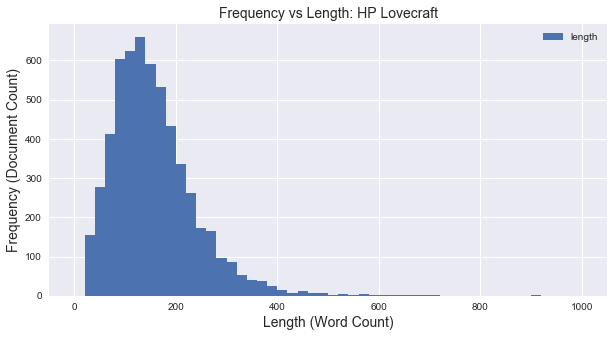

In [10]:
texts[texts.author=='HPL'].plot(bins=50, kind='hist', range=[0,1000], figsize=(10,5))
plt.title('Frequency vs Length: HP Lovecraft', size=14)
plt.xlabel('Length (Word Count)',size=14)
plt.ylabel('Frequency (Document Count)',size=14)

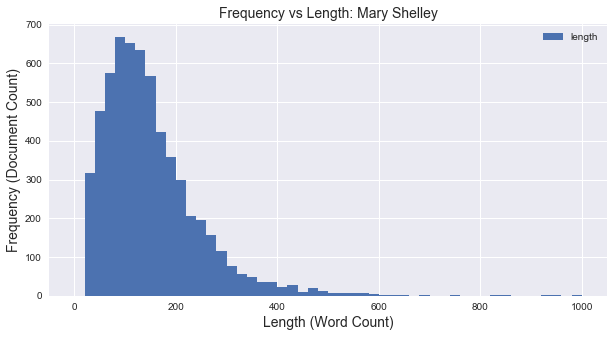

In [11]:
texts[texts.author=='MWS'].plot(bins=50, kind='hist', range=[0,1000], figsize=(10,5))
plt.title('Frequency vs Length: Mary Shelley', size=14)
plt.xlabel('Length (Word Count)',size=14)
plt.ylabel('Frequency (Document Count)',size=14)

## feature selection
Because the categories are small, the target data X will be the text prose and the target response y is the author.  In other words, this will identify the author by looking at the words the author uses.  Advanced features such as sentiment and others will be based on hyperparamater tuning! 

In [12]:
# choose X and y
X = texts.text
y = texts.author

## experiment 1 split & vectorize
The first method splits the training set between train and test data.  It will hold onto 70% for training.  First, it is important to tune the pipelines to see what would be the best combination for manipulating the data to get higher accuracy.  Two pipelines are performed: both with the same vectorizer but different classifiers.

### split
Here, the training and test data are split using a popular sklearn function, with stratification important to avoid biased data manipulation.

In [13]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### tune

In [19]:
# import stop words to reduce noise
stop_words = get_stop_words('en')

---
### vectorize
This will use the CountVectorizer function with the hyperparameters provided.  

In [20]:
vect_A1 = CountVectorizer(binary=True, ngram_range=(1,2), stop_words=stop_words, max_df=0.5)
nb_A1 = MultinomialNB(alpha=0.1)

### fit and predict
Using the pipeline, fit with the training data and then test with the performing data.

In [21]:
# fit & transform with vectorizer
X_train_dtm = vect_A1.fit_transform(X_train)

# fit with classifer
nb_A1.fit(X_train_dtm, y_train)

# predict with classifier
y_pred_train = nb_A1.predict(X_train_dtm)

# transform with vectorizer, then predict with classifier
X_test_dtm = vect_A1.transform(X_test)
y_pred_test = nb_A1.predict(X_test_dtm)

### evaluation
Here, this will evaluate with three metrics: accuracy score, confusion matrix, and classification report.

In [22]:
print(metrics.accuracy_score(y_pred_train, y_train))

0.997344047943


In [23]:
print(metrics.accuracy_score(y_pred_test, y_test))

0.849029622063


In [24]:
print(metrics.confusion_matrix(y_pred_train, y_train))

[[5905    6    7]
 [   8 4219    5]
 [  12    1 4521]]


In [25]:
print(metrics.confusion_matrix(y_pred_test, y_test))

[[1669  136  142]
 [ 133 1188   70]
 [ 173   85 1299]]


In [26]:
print(metrics.classification_report(y_pred_train, y_train))

             precision    recall  f1-score   support

        EAP       1.00      1.00      1.00      5918
        HPL       1.00      1.00      1.00      4232
        MWS       1.00      1.00      1.00      4534

avg / total       1.00      1.00      1.00     14684



In [27]:
print(metrics.classification_report(y_pred_test,y_test))

             precision    recall  f1-score   support

        EAP       0.85      0.86      0.85      1947
        HPL       0.84      0.85      0.85      1391
        MWS       0.86      0.83      0.85      1557

avg / total       0.85      0.85      0.85      4895



In [28]:
exp1_A_lst1 = nb_A1.predict_proba(X_test_dtm)
exp1_A_lst2 = nb_A1.predict(X_test_dtm)

### feature importance
Here, this will extract the ten most important features per class with a probability score.

In [29]:
# store vocabulary of X_train
X_train_tokens = vect_A1.get_feature_names()

# rows represent classes
print(len(X_train_tokens), nb_A1.feature_count_.shape)

183254 (3, 183254)


In [30]:
# Naive Bayes counts the number of times each token appears in each class
nb_A1.feature_count_

array([[ 1.,  2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [31]:
# number of times each token appears across all EAP messages
EAP_token_count = nb_A1.feature_count_[0,:]

# number of times each token appears across all HPL messages
HPL_token_count = nb_A1.feature_count_[1,:]

# number of times each token appears across all MWS messages
MWS_token_count = nb_A1.feature_count_[2,:]

In [32]:
# DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 'EAP':EAP_token_count, 'HPL':HPL_token_count, 'MWS':MWS_token_count}).set_index('token')
tokens.sample(5, random_state=6)

,EAP,HPL,MWS
token,,,
heath unvisited,0.0,0.0,1.0
tin stovepipe,0.0,1.0,0.0
wed virtuous,0.0,1.0,0.0
knew wonderfully,1.0,0.0,0.0
german understand,1.0,0.0,0.0


In [33]:
# Naive Bayes counts the number of observations 
nb_A1.class_count_

array([ 5925.,  4226.,  4533.])

In [34]:
# avoid dividing by 0 (class imbalance)
tokens['EAP'] = tokens.EAP + 1
tokens['HPL'] = tokens.HPL + 1
tokens['MWS'] = tokens.MWS + 1
tokens.sample(5, random_state=6)

,EAP,HPL,MWS
token,,,
heath unvisited,1.0,1.0,2.0
tin stovepipe,1.0,2.0,1.0
wed virtuous,1.0,2.0,1.0
knew wonderfully,2.0,1.0,1.0
german understand,2.0,1.0,1.0


In [35]:
# convert into frequencies 
tokens['EAP'] = tokens.EAP / nb_A1.class_count_[0]
tokens['HPL'] = tokens.HPL / nb_A1.class_count_[1]
tokens['MWS'] = tokens.MWS / nb_A1.class_count_[2]
tokens.sample(5, random_state=6)

,EAP,HPL,MWS
token,,,
heath unvisited,0.000169,0.000237,0.000441
tin stovepipe,0.000169,0.000473,0.000221
wed virtuous,0.000169,0.000473,0.000221
knew wonderfully,0.000338,0.000237,0.000221
german understand,0.000338,0.000237,0.000221


In [36]:
# examine DataFrame by author
for name in tokens.columns:
    print(tokens[name].nlargest(10),'\n')

token
upon    0.116962
one     0.071730
now     0.060422
said    0.044895
will    0.044726
made    0.033418
time    0.033418
well    0.032911
even    0.032574
say     0.032574
Name: EAP, dtype: float64 

token
one       0.078325
old       0.068386
now       0.052532
man       0.049219
seemed    0.049219
like      0.047089
night     0.043540
time      0.041884
though    0.041410
saw       0.039754
Name: HPL, dtype: float64 

token
one        0.069270
now        0.058460
will       0.055813
life       0.050739
yet        0.049195
raymond    0.044341
love       0.042797
heart      0.041915
might      0.041253
even       0.040150
Name: MWS, dtype: float64 



---
### vectorize w/ LogisticRegression()
This uses LogisticRegression() with the hyperparameter tuning mentioned above.

In [37]:
vect_A1 = CountVectorizer(binary=True, ngram_range=(1,1), stop_words=stop_words, max_df=0.75)
logreg_A1 = LogisticRegression(C=1.0)

### fit and predict w/ LogisticRegression()
Fit the training set, apply it on the test set, and create a prediction model.

In [38]:
# fit & transform with vectorizer
X_train_dtm = vect_A1.fit_transform(X_train)

# fit with classifer
logreg_A1.fit(X_train_dtm, y_train)

# predict with classifier
y_pred_train = logreg_A1.predict(X_train_dtm)

# transform with vectorizer, then predict with classifier
X_test_dtm = vect_A1.transform(X_test)
y_pred_test = logreg_A1.predict(X_test_dtm)

### evaluation w/ LogisticRegression()
Here, this will evaluate with three metrics: accuracy score, confusion matrix, and classification report.

In [39]:
print(metrics.accuracy_score(y_pred_train, y_train))

0.968332879324


In [40]:
print(metrics.accuracy_score(y_pred_test, y_test))

0.81164453524


In [41]:
print(metrics.confusion_matrix(y_pred_train, y_train))

[[5832  125  188]
 [  26 4070   28]
 [  67   31 4317]]


In [42]:
print(metrics.confusion_matrix(y_pred_test, y_test))

[[1716  246  256]
 [ 111 1078   76]
 [ 148   85 1179]]


In [43]:
print(metrics.classification_report(y_pred_train, y_train))

             precision    recall  f1-score   support

        EAP       0.98      0.95      0.97      6145
        HPL       0.96      0.99      0.97      4124
        MWS       0.95      0.98      0.96      4415

avg / total       0.97      0.97      0.97     14684



In [44]:
print(metrics.classification_report(y_pred_test,y_test))

             precision    recall  f1-score   support

        EAP       0.87      0.77      0.82      2218
        HPL       0.77      0.85      0.81      1265
        MWS       0.78      0.83      0.81      1412

avg / total       0.82      0.81      0.81      4895



In [45]:
exp1_A_lst3 = logreg_A1.predict_proba(X_test_dtm)
exp1_A_lst4 = logreg_A1.predict(X_test_dtm)

### feature importance
Here, this will extract the ten most important features per class with a probability score.

In [61]:
# Get feature names
X_train_tokens = vect_A1.get_feature_names()

# Calculate coefficient into odd, calculate odd into probability
log_reg_prob=np.exp(logreg_A1.coef_)/(np.exp(logreg_A1.coef_)+1)

In [62]:
# coefficients each token appears across all classes
EAP_token_prob = log_reg_prob[0,:]
HPL_token_prob = log_reg_prob[1,:]
MWS_token_prob = log_reg_prob[2,:]

# number of times each token appears
EAP_token_coef = logreg_A1.coef_[0,:]
HPL_token_coef = logreg_A1.coef_[1,:]
MWS_token_coef = logreg_A1.coef_[2,:]

In [65]:
# Coefficient DataFrame
coefs = pd.DataFrame({'token':X_train_tokens, 
                       'EAP':EAP_token_coef, 
                       'HPL':HPL_token_coef, 
                       'MWS':MWS_token_coef}).set_index('token')

In [66]:
# examine DataFrame by author
for name in coefs.columns:
    print(coefs[name].nlargest(10),'\n')

token
dupin      2.307535
minutes    1.970809
evident    1.886097
color      1.672222
madame     1.578178
ellison    1.570647
lustre     1.568421
pompey     1.557530
drawer     1.533857
balloon    1.523219
Name: EAP, dtype: float64 

token
gilman       2.284341
west         2.239494
though       2.140185
innsmouth    2.134974
jermyn       2.120193
despite      2.022103
pickman      1.993617
johansen     1.933906
later        1.910848
musides      1.896967
Name: HPL, dtype: float64 

token
raymond      3.539530
perdita      3.143836
adrian       2.907555
idris        2.426964
sister       2.394821
towards      2.386876
elizabeth    2.192059
windsor      2.189323
miserable    2.131024
plague       2.039970
Name: MWS, dtype: float64 



In [70]:
# Probability DataFrame
probs = pd.DataFrame({'token':X_train_tokens, 
                       'EAP':EAP_token_prob, 
                       'HPL':HPL_token_prob, 
                       'MWS':MWS_token_prob}).set_index('token')

In [71]:
# examine DataFrame by author
for name in probs.columns:
    print(probs[name].nlargest(10),'\n')

token
dupin      0.909499
minutes    0.877698
evident    0.868310
color      0.841872
madame     0.828946
ellison    0.827876
lustre     0.827558
pompey     0.825999
drawer     0.822570
balloon    0.821012
Name: EAP, dtype: float64 

token
gilman       0.907572
west         0.903740
though       0.894748
innsmouth    0.894256
jermyn       0.892850
despite      0.883098
pickman      0.880125
johansen     0.873681
later        0.871114
musides      0.869548
Name: HPL, dtype: float64 

token
raymond      0.971792
perdita      0.958665
adrian       0.948219
idris        0.918860
sister       0.916432
towards      0.915821
elizabeth    0.899534
windsor      0.899287
miserable    0.893882
plague       0.884930
Name: MWS, dtype: float64 



---
---

## experiment 2 vectorize & split
The second method takes the entire corpus and then splits the data.  Two pipelines are performed: both with the same vectorizer but different classifiers.

### tune
Like before, it will tune first.  Then it will apply it to fit and predict.  

In [72]:
# initiate the vectorizer
pipeline_B1 = Pipeline([
    ('vect', CountVectorizer()),
    ('nb', MultinomialNB())
])

# parameters
parameters_B1 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
    'nb__alpha': [0.05, 0.1, 1.0, 2.0]
}

In [73]:
# gridsearch
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
grid_search_B1 = GridSearchCV(pipeline_B1, 
                           parameters_B1, 
                           n_jobs=1, 
                           cv=5
                )

In [74]:
# fit model to determine best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_B1.steps])
print("parameters:")
pprint(parameters_B1, depth=2)

%time grid_search_B1.fit(X, y)

Performing grid search...
pipeline: ['vect', 'nb']
parameters:
{'nb__alpha': [0.05, 0.1, 1.0, 2.0],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((...), (...), (...))}
CPU times: user 7min 26s, sys: 12.1 s, total: 7min 38s
Wall time: 7min 40s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'nb__alpha': [0.05, 0.1, 1.0, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [75]:
print("Best score: %0.3f" % grid_search_B1.best_score_)
print("Best parameters set:")

best_parameters = grid_search_B1.best_estimator_.get_params()

for param_name in sorted(parameters_B1.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.859
Best parameters set:
	nb__alpha: 0.1
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [76]:
# initiate the vectorizer
pipeline_B2 = Pipeline([
    ('vect', CountVectorizer()),
    ('logreg', LogisticRegression())
])

# parameters
parameters_B2 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
    'logreg__C': [0.05, 0.1, 1.0, 2.0], # positive float
}

In [77]:
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
grid_search_B2 = GridSearchCV(pipeline_B2, 
                           parameters_B2, 
                           n_jobs=1, 
                           cv=5
                )

In [78]:
# fit model to determine best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_B2.steps])
print("parameters:")
pprint(parameters_B2, depth=2)

%time grid_search_B2.fit(X_train, y_train)

Performing grid search...
pipeline: ['vect', 'logreg']
parameters:
{'logreg__C': [0.05, 0.1, 1.0, 2.0],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((...), (...), (...))}
CPU times: user 16min 9s, sys: 3min 23s, total: 19min 33s
Wall time: 9min 2s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'logreg__C': [0.05, 0.1, 1.0, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
print("Best score: %0.3f" % grid_search_B2.best_score_)
print("Best parameters set:")

best_parameters = grid_search_B2.best_estimator_.get_params()

for param_name in sorted(parameters_B2.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.809
Best parameters set:
	logreg__C: 1.0
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)


### vectorize

In [97]:
# import and instantiate CountVectorizer (with the default parameters)
vect_B1 = CountVectorizer(max_df=0.5, stop_words=stop_words, ngram_range=(1,2))

In [98]:
# learn the 'vocabulary' of the training data (occurs in-place)
X_dtm = vect_B1.fit_transform(X)

### split

In [99]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### fit & predict

In [100]:
# transform 
X_train_dtm = vect_B1.transform(X_train)
X_test_dtm = vect_B1.transform(X_test)

In [101]:
# set up Multinomial NB
nb = MultinomialNB(alpha=0.5)

In [102]:
# fit
nb.fit(X_dtm, y)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [103]:
# predict with training class
y_train_pred = nb.predict(X_train_dtm)

In [104]:
# predict with testing class
y_test_pred = nb.predict(X_test_dtm)

### evaluate

In [105]:
# accuracy score, train
metrics.accuracy_score(y_train, y_train_pred)

0.99318986652138386

In [106]:
# accuracy score, test
metrics.accuracy_score(y_test, y_test_pred)

0.99448416751787538

In [107]:
# confusion matrix, train
metrics.confusion_matrix(y_train, y_train_pred)

array([[5877,   20,   28],
       [  19, 4201,    6],
       [  23,    4, 4506]])

In [108]:
# confusion matrix, test
metrics.confusion_matrix(y_test, y_test_pred)

array([[1961,    3,   11],
       [   4, 1403,    2],
       [   6,    1, 1504]])

In [109]:
# classification report, train
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       0.99      0.99      0.99      5925
        HPL       0.99      0.99      0.99      4226
        MWS       0.99      0.99      0.99      4533

avg / total       0.99      0.99      0.99     14684



In [110]:
# classification report, test
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.99      0.99      0.99      1975
        HPL       1.00      1.00      1.00      1409
        MWS       0.99      1.00      0.99      1511

avg / total       0.99      0.99      0.99      4895



In [111]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
exp1_B_lst1 = nb.predict_proba(X_test_dtm)
exp1_B_lst2 = nb.predict(X_test_dtm)

### feature importance

In [112]:
# store vocabulary of X_train
X_train_tokens = vect_B1.get_feature_names()

# rows represent classes
print(len(X_train_tokens), nb.feature_count_.shape)

234396 (3, 234396)


In [113]:
# number of times each token appears across all EAP messages
EAP_token_count = nb.feature_count_[0,:]

# number of times each token appears across all HPL messages
HPL_token_count = nb.feature_count_[1,:]

# number of times each token appears across all MWS messages
MWS_token_count = nb.feature_count_[2,:]

In [114]:
# DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 
                       'EAP':EAP_token_count, 
                       'HPL':HPL_token_count, 
                       'MWS':MWS_token_count}).set_index('token')

In [115]:
# avoid dividing by 0 (class imbalance)
tokens['EAP'] = tokens.EAP + 1
tokens['HPL'] = tokens.HPL + 1
tokens['MWS'] = tokens.MWS + 1

In [117]:
# convert into frequencies 
tokens['EAP'] = tokens.EAP / nb_A1.class_count_[0]
tokens['HPL'] = tokens.HPL / nb_A1.class_count_[1]
tokens['MWS'] = tokens.MWS / nb_A1.class_count_[2]

In [118]:
# examine DataFrame by author
for name in tokens.columns:
    print(tokens[name].nlargest(10),'\n')

token
upon      0.173165
one       0.110717
now       0.080000
will      0.066667
said      0.060253
little    0.046582
say       0.045232
well      0.044895
made      0.044557
even      0.044219
Name: EAP, dtype: float64 

token
one       0.116422
old       0.092996
now       0.070989
man       0.066493
like      0.064837
seemed    0.064600
night     0.060577
things    0.056555
time      0.056555
saw       0.055845
Name: HPL, dtype: float64 

token
one        0.105449
will       0.100375
now        0.088021
life       0.073902
yet        0.070373
love       0.060666
us         0.060225
raymond    0.059784
might      0.059563
heart      0.058681
Name: MWS, dtype: float64 



### vectorize
This will use the parameters that best maximize the accuracy. 

In [119]:
# import and instantiate CountVectorizer (with the default parameters)
vect_B2 = CountVectorizer(max_df=0.75, ngram_range=(1,1))

In [120]:
X_dtm = vect_B2.fit_transform(X)

### split
The split is the same; the training data will be used to evaluate the model.

In [121]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### fit & predict w/ LogisticRegression()
This will keep the vectorization and split the same.  However, it will use LogisticRegression() over MultinomialNB().  

In [122]:
# transform 
X_train_dtm = vect_B2.transform(X_train)
X_test_dtm = vect_B2.transform(X_test)

In [123]:
logreg = LogisticRegression(C=1.0)

In [124]:
logreg.fit(X_dtm, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
# predict with training class
y_train_pred = logreg.predict(X_train_dtm)

In [126]:
# predict with testing class
y_test_pred = logreg.predict(X_test_dtm)

### evaluate

In [127]:
# accuracy score, train
metrics.accuracy_score(y_train, y_train_pred)

0.96778806864614542

In [128]:
# accuracy score, test
metrics.accuracy_score(y_test, y_test_pred)

0.96976506639427984

In [129]:
# confusion matrix, train
metrics.confusion_matrix(y_train, y_train_pred)

array([[5805,   35,   85],
       [ 119, 4078,   29],
       [ 176,   29, 4328]])

In [130]:
# print confusion matrix
metrics.confusion_matrix(y_test, y_test_pred)

array([[1934,   17,   24],
       [  32, 1369,    8],
       [  52,   15, 1444]])

In [131]:
# classification report, train
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       0.95      0.98      0.97      5925
        HPL       0.98      0.96      0.97      4226
        MWS       0.97      0.95      0.96      4533

avg / total       0.97      0.97      0.97     14684



In [132]:
# classification report, test
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.96      0.98      0.97      1975
        HPL       0.98      0.97      0.97      1409
        MWS       0.98      0.96      0.97      1511

avg / total       0.97      0.97      0.97      4895



In [133]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
y_pred_prob = logreg.predict_proba(X_test_dtm)

In [134]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
exp1_B_lst3 = logreg.predict_proba(X_test_dtm)
exp1_B_lst4 = logreg.predict(X_test_dtm)

### feature importance

In [135]:
# Get feature names
X_train_tokens = vect_B2.get_feature_names()

# Calculate coefficient into odd, calculate odd into probability
log_reg_prob=np.exp(logreg.coef_)/(np.exp(logreg.coef_)+1)

In [138]:
# coefficients each token appears across all classes
EAP_token_prob = log_reg_prob[0,:]
HPL_token_prob = log_reg_prob[1,:]
MWS_token_prob = log_reg_prob[2,:]

# number of times each token appears
EAP_token_coef = logreg.coef_[0,:]
HPL_token_coef = logreg.coef_[1,:]
MWS_token_coef = logreg.coef_[2,:]

In [139]:
# Coefficient DataFrame
coefs = pd.DataFrame({'token':X_train_tokens, 
                       'EAP':EAP_token_coef, 
                       'HPL':HPL_token_coef, 
                       'MWS':MWS_token_coef}).set_index('token')

In [140]:
# examine DataFrame by author
for name in coefs.columns:
    print(coefs[name].nlargest(10),'\n')

token
dupin        2.226379
minutes      1.940119
madame       1.841242
precisely    1.788356
lady         1.785235
kate         1.737145
evident      1.730778
jupiter      1.706281
nose         1.695168
amid         1.657188
Name: EAP, dtype: float64 

token
despite      2.403688
later        2.396820
jermyn       2.327398
gilman       2.320025
birch        2.223038
innsmouth    2.196929
though       2.180848
brown        2.089596
normal       2.079948
johansen     2.077081
Name: HPL, dtype: float64 

token
raymond      3.711152
perdita      3.289060
adrian       3.082172
idris        2.583584
elizabeth    2.401328
plague       2.367171
windsor      2.158187
cottage      2.152484
towards      2.127779
miserable    2.100854
Name: MWS, dtype: float64 



In [141]:
# Probability DataFrame
probs = pd.DataFrame({'token':X_train_tokens, 
                       'EAP':EAP_token_prob, 
                       'HPL':HPL_token_prob, 
                       'MWS':MWS_token_prob}).set_index('token')

In [142]:
# examine DataFrame by author
for name in probs.columns:
    print(probs[name].nlargest(10),'\n')

token
dupin        0.902594
minutes      0.874365
madame       0.863096
precisely    0.856726
lady         0.856342
kate         0.850324
evident      0.849512
jupiter      0.846353
nose         0.844903
amid         0.839860
Name: EAP, dtype: float64 

token
despite      0.917108
later        0.916584
jermyn       0.911121
gilman       0.910522
birch        0.902299
innsmouth    0.899973
though       0.898516
brown        0.889888
normal       0.888939
johansen     0.888656
Name: HPL, dtype: float64 

token
raymond      0.976134
perdita      0.964052
adrian       0.956151
idris        0.929798
elizabeth    0.916929
plague       0.914289
windsor      0.896431
cottage      0.895901
towards      0.893574
miserable    0.890986
Name: MWS, dtype: float64 

